# Imports | Reads | Filter Patients (Phase 01)

In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

In [2]:
# Read MIMICs CSV file
mimic_df = pd.read_csv("CSV\\exports\\final\\mimic_mean_final.csv")

# Read eICUs CSV file
eicu_df = pd.read_csv("CSV\\exports\\final\\eicu_mean_final.csv")

In [3]:
day = 10

# Filter icu stay less than 10 days
mimic_df = mimic_df[mimic_df['los'] < day]

# Filter icu stay less than 10 days
eicu_df = eicu_df[eicu_df['los'] < day]

In [4]:
"""
I'm gonna concat and split the mimic and icu
at this point. I must create the same columns
from the tranformation of categorical data.
"""
row_count = mimic_df.shape[0]
print(f"Row count: {row_count}")

Row count: 48992


In [5]:
# Concat dataframes
df_combined = pd.concat([mimic_df, eicu_df], ignore_index=True)

# Find all categorical columns in mimic
categorical_columns = df_combined.select_dtypes(include=['object', 'category']).columns.tolist()

# Apply one-hot encoding to all categorical columns
df_encoded = pd.get_dummies(df_combined, columns=categorical_columns)

# Split the concatenate dataframe
mimic_df = df_encoded.iloc[:row_count, :]
eicu_df = df_encoded.iloc[row_count:, :]

# Split Training - Validation - Test Set (Phase 02)

In [7]:
total_test_val_perc = 0.2
split_between_test_val_perc = 0.5

# Group data by subject_id and hadm_id
grouped_df = mimic_df.groupby(['subject_id', 'hadm_id'])

# Get a new dataframe with one row per patient (subject_id, hadm_id) pair
patient_df = grouped_df['hospital_expire_flag'].first().reset_index()

# Split the patient_df into training (80%), validation (10%), and test (10%) while keeping the ratio of hospital_expired_flag
train, temp = train_test_split(patient_df, test_size=total_test_val_perc, stratify=patient_df['hospital_expire_flag'], random_state=42)
val, test = train_test_split(temp, test_size=split_between_test_val_perc, stratify=temp['hospital_expire_flag'], random_state=42)

# Step 4: Merge back with the original df to get the rows for each patient in the splits
train_df = mimic_df.merge(train[['subject_id', 'hadm_id']], on=['subject_id', 'hadm_id'], how='inner')
val_df = mimic_df.merge(val[['subject_id', 'hadm_id']], on=['subject_id', 'hadm_id'], how='inner')
test_df = mimic_df.merge(test[['subject_id', 'hadm_id']], on=['subject_id', 'hadm_id'], how='inner')

# Check the sizes of the splits
print(f'Training set size: {train_df.shape[0]}')
print(f'Validation set size: {val_df.shape[0]}')
print(f'Test set size: {test_df.shape[0]}')

Training set size: 39184
Validation set size: 4896
Test set size: 4912


# Split label from Train - Validation - Test Sets (Phase 04)

In [9]:
# External validation from eICU
X_external = eicu_df.drop(columns=['hospital_expire_flag', 'los', 'subject_id', 'hadm_id', 'row_count', 'Time_Zone'])
y_external = eicu_df['los']

# Separate features and target for the training, validation, and test sets
X_train = train_df.drop(columns=['hospital_expire_flag', 'los', 'subject_id', 'hadm_id', 'row_count', 'Time_Zone'])
y_train = train_df['los']

X_validate = val_df.drop(columns=['hospital_expire_flag', 'los', 'subject_id', 'hadm_id', 'row_count', 'Time_Zone'])
y_validate = val_df['los']

X_test = test_df.drop(columns=['hospital_expire_flag', 'los', 'subject_id', 'hadm_id', 'row_count', 'Time_Zone'])
y_test = test_df['los']

In [10]:
# Path
save_path = 'CSV/exports/test/'

# Check if the directory exists, and if not, create it
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Save external validation set from eICU
X_external.to_csv(save_path + 'X_external.csv', index=False)
y_external.to_csv(save_path + 'y_external.csv', index=False)

# Save training, validation, and test sets
X_train.to_csv(save_path + 'X_train.csv', index=False)
y_train.to_csv(save_path + 'y_train.csv', index=False)

X_validate.to_csv(save_path + 'X_validate.csv', index=False)
y_validate.to_csv(save_path + 'y_validate.csv', index=False)

X_test.to_csv(save_path + 'X_test.csv', index=False)
y_test.to_csv(save_path + 'y_test.csv', index=False)

# Check Missing Values

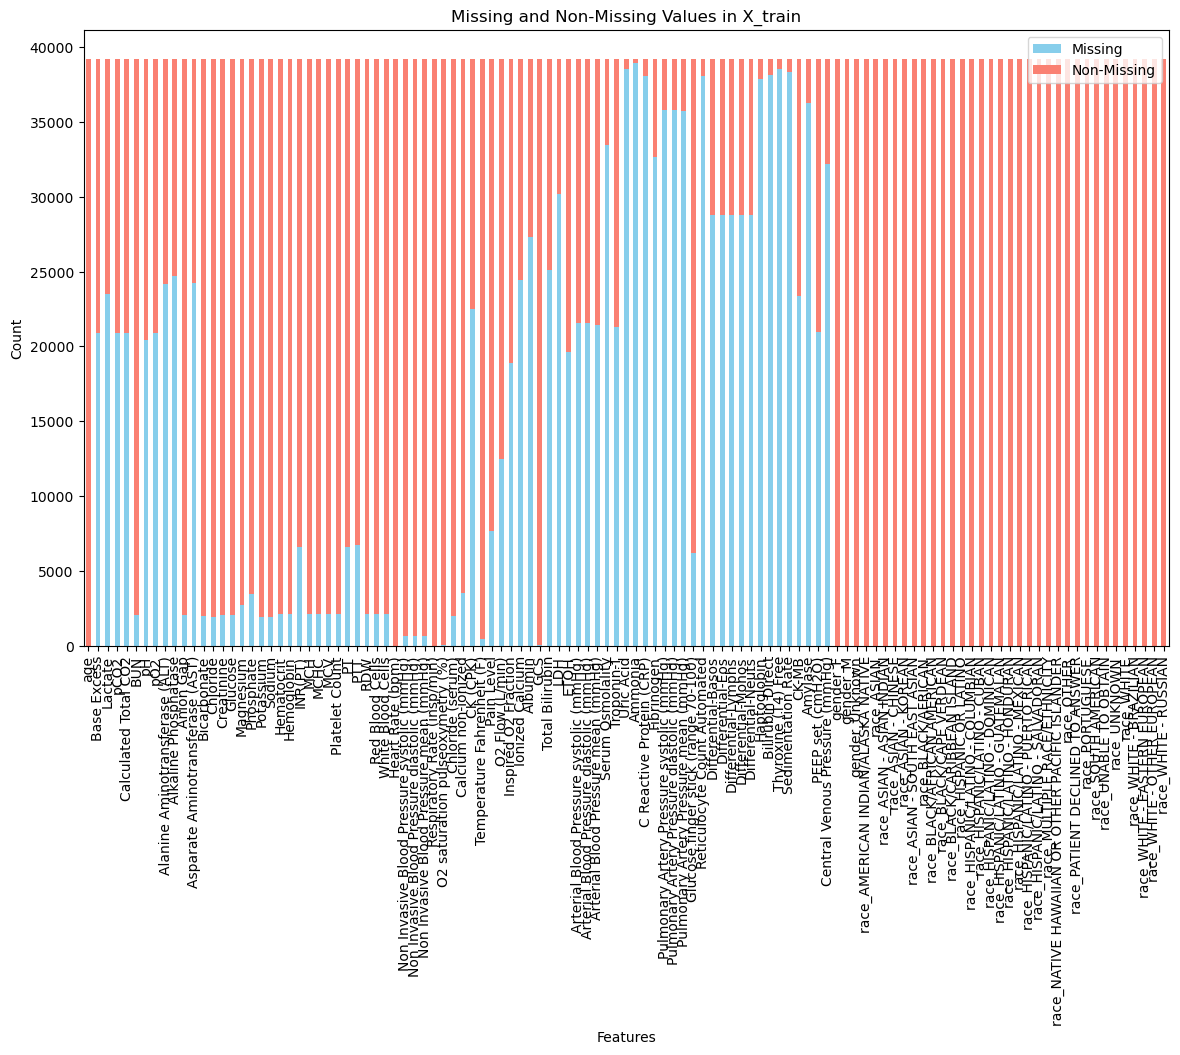

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_missing_values_stacked(df, title='Missing and Non-Missing Values per Feature'):
    # Calculate missing values
    missing_count = df.isnull().sum()
    non_missing_count = df.notnull().sum()
    
    # Create a DataFrame to plot
    missing_df = pd.DataFrame({'Missing': missing_count, 'Non-Missing': non_missing_count})
    missing_df = missing_df[missing_df.sum(axis=1) > 0]  # Keep only features with missing values
    
    # Plot a stacked bar chart
    missing_df.plot(kind='bar', stacked=True, figsize=(14, 8), color=['skyblue', 'salmon'])
    plt.title(title)
    plt.xlabel('Features')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()

# Usage example for X_train
visualize_missing_values_stacked(X_train, title='Missing and Non-Missing Values in X_train')


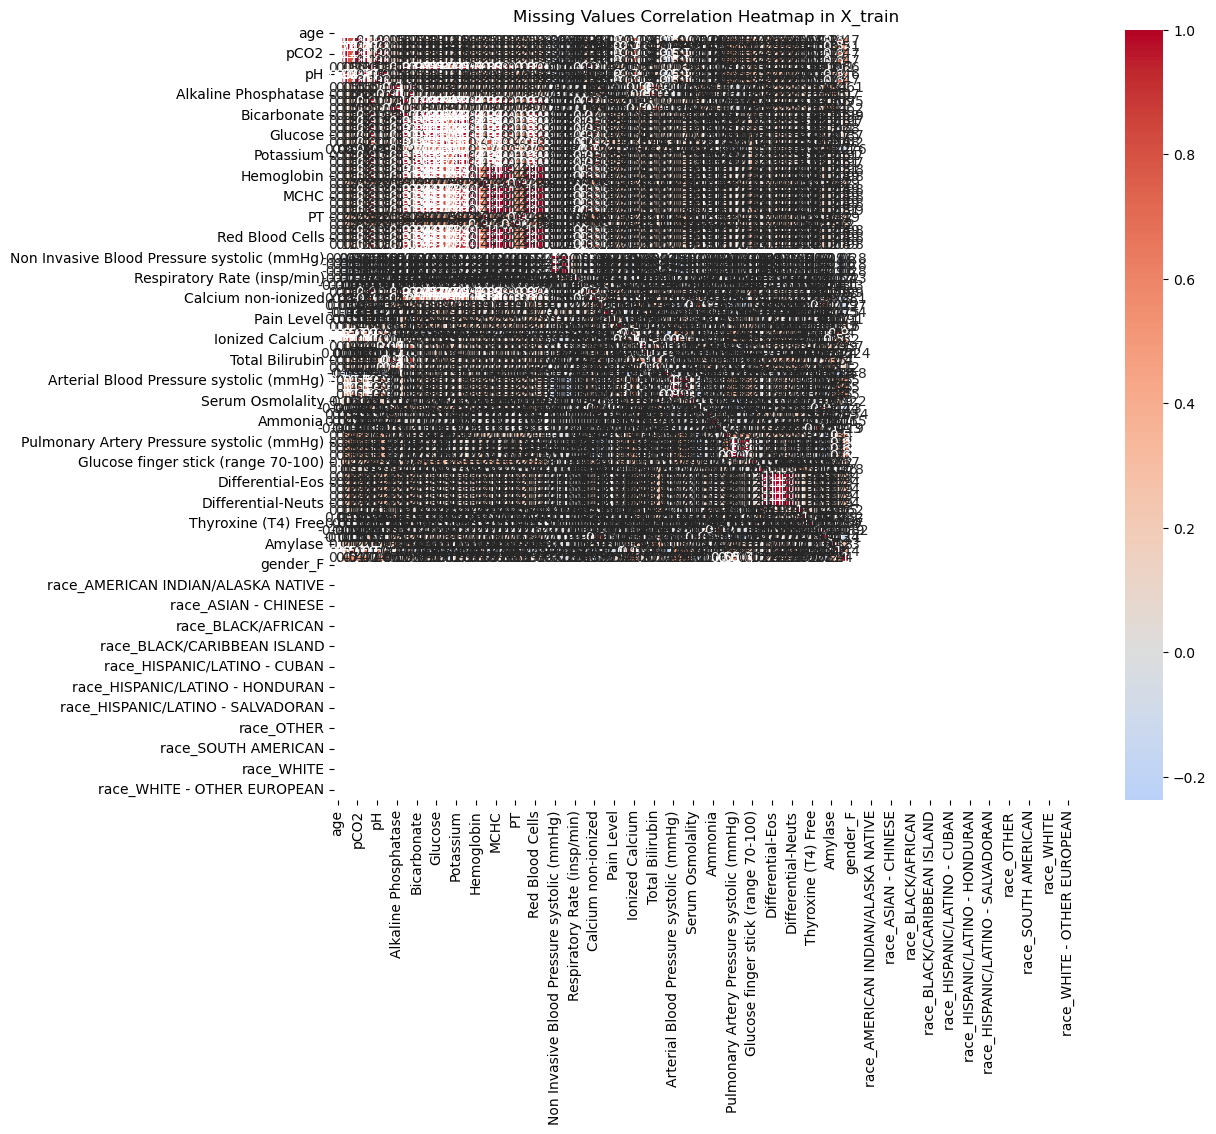

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_missing_values_correlation_heatmap(df, title='Missing Values Correlation Heatmap'):
    # Calculate the correlation matrix of missing values
    corr_matrix = df.isnull().corr()

    # Plot the correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5, linecolor='white')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

# Usage example for X_train
visualize_missing_values_correlation_heatmap(X_train, title='Missing Values Correlation Heatmap in X_train')


C:\Users\Dimopoulos\AppData\Local\Temp\ipykernel_12804\3053303424.py:34: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend([bars[0], bars[-1], 'Threshold Line'], ['Numerical', 'Categorical', 'Threshold Line'], loc='upper right')


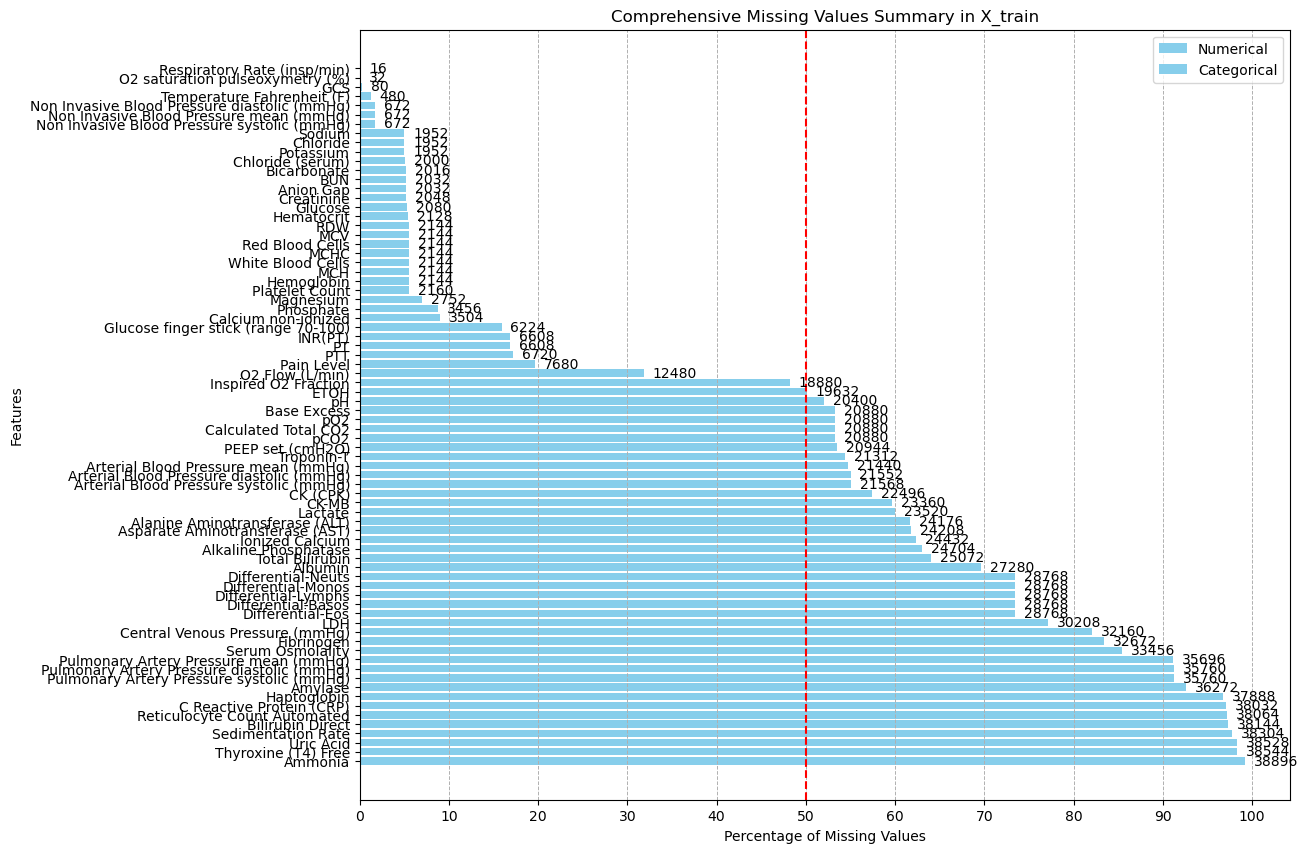

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_missing_values_summary(df, title='Missing Values Summary'):
    # Calculate the percentage and count of missing values
    missing_count = df.isnull().sum()
    missing_percent = (missing_count / len(df)) * 100

    # Create a DataFrame to plot
    missing_df = pd.DataFrame({'Missing Count': missing_count, 'Missing Percent': missing_percent})
    missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Percent', ascending=False)
    
    # Determine feature types for color coding
    feature_types = ['Categorical' if df[col].dtype == 'object' else 'Numerical' for col in missing_df.index]
    color_map = {'Numerical': 'skyblue', 'Categorical': 'salmon'}
    colors = [color_map[ftype] for ftype in feature_types]

    # Plot the missing percentage as a horizontal bar plot
    plt.figure(figsize=(12, 10))
    bars = plt.barh(missing_df.index, missing_df['Missing Percent'], color=colors)
    
    # Add a threshold line (e.g., 50%)
    threshold = 50
    plt.axvline(x=threshold, color='red', linestyle='--', label=f'{threshold}% Threshold')

    # Annotate the bars with count of missing values
    for bar, count in zip(bars, missing_df['Missing Count']):
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{int(count)}', va='center')

    # Add legend and labels
    plt.title(title)
    plt.xlabel('Percentage of Missing Values')
    plt.ylabel('Features')
    plt.legend([bars[0], bars[-1], 'Threshold Line'], ['Numerical', 'Categorical', 'Threshold Line'], loc='upper right')
    plt.xticks(np.arange(0, 101, 10))
    plt.grid(axis='x', linestyle='--', linewidth=0.7)
    plt.show()

# Usage example for X_train
visualize_missing_values_summary(X_train, title='Comprehensive Missing Values Summary in X_train')


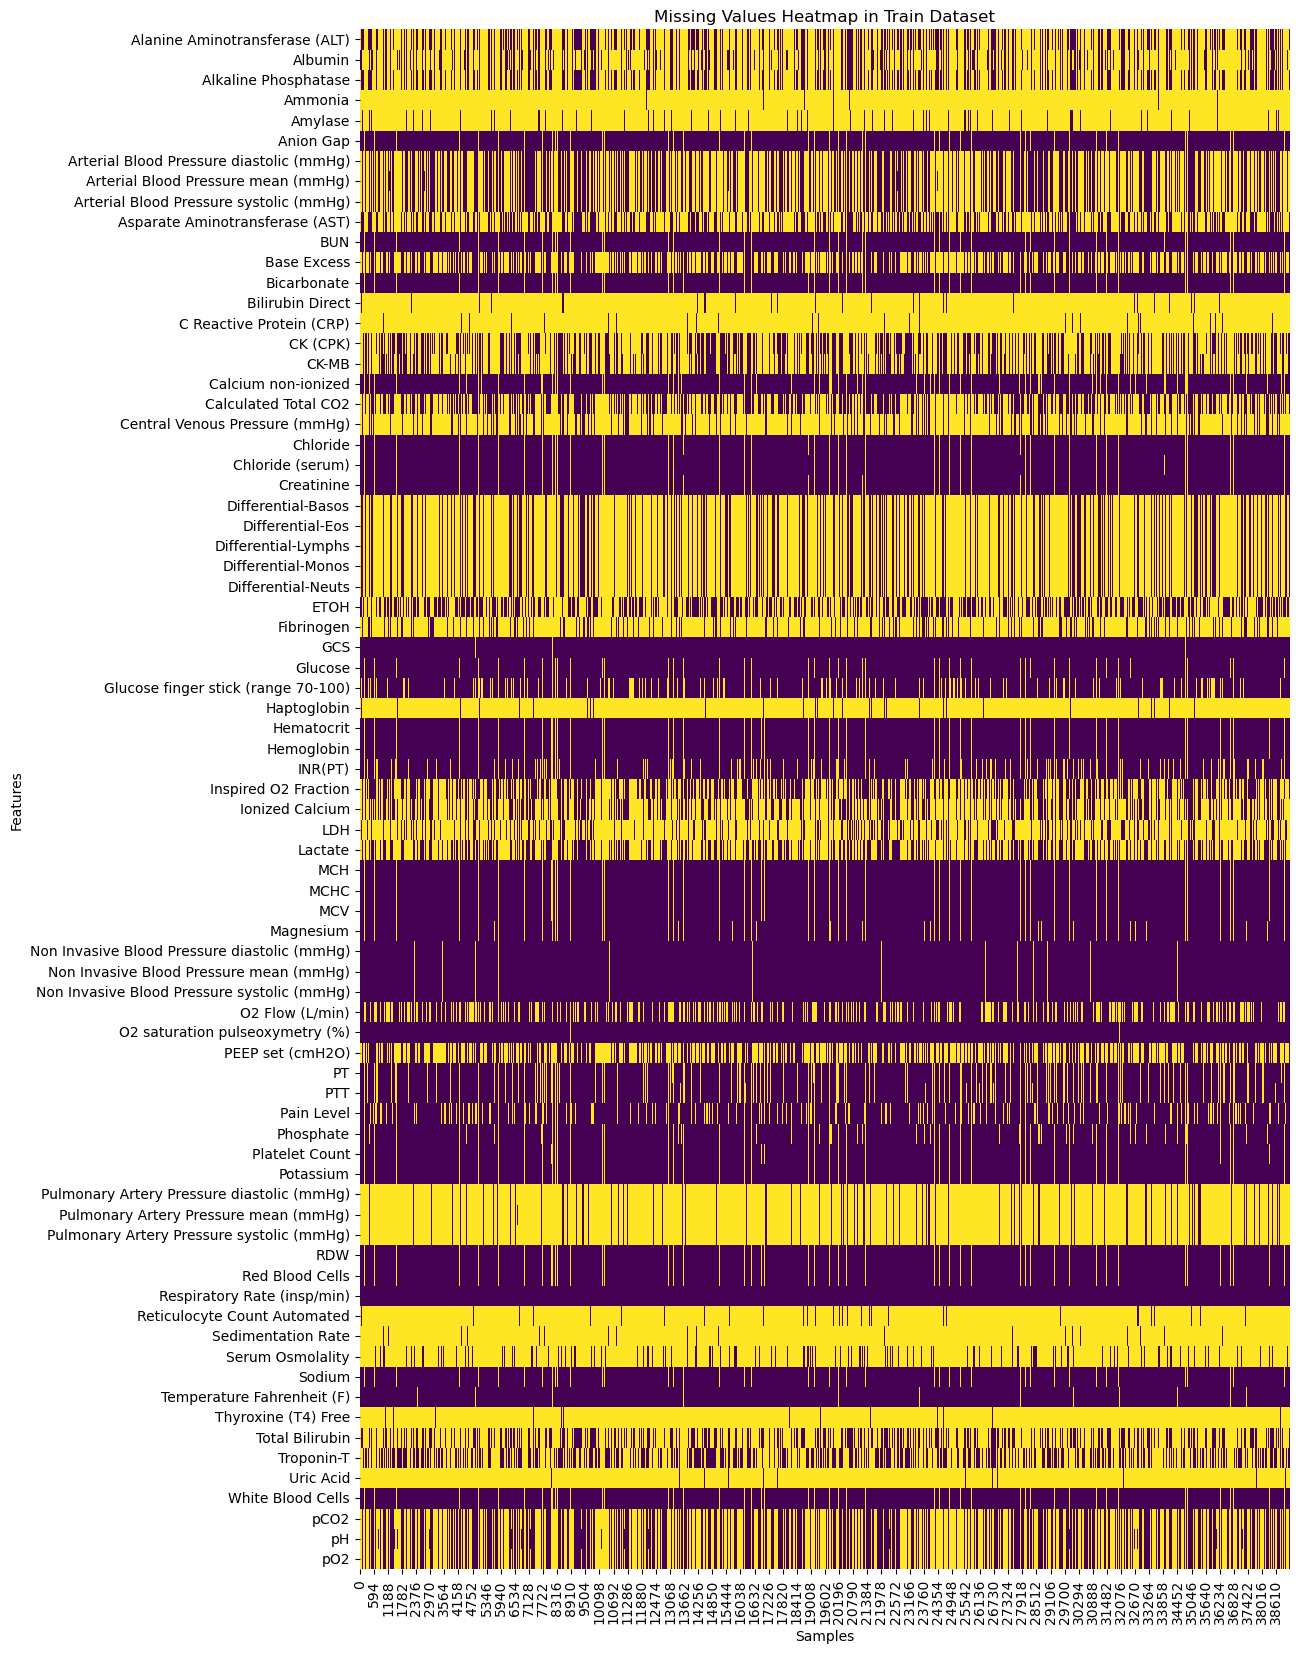

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_missing_values_heatmap(df, title='Missing Values Heatmap'):
    # Exclude features without missing values
    df_with_missing = df.loc[:, df.isnull().any()]

    # Sort the columns (features) alphabetically
    df_with_missing = df_with_missing[sorted(df_with_missing.columns)]

    # Adjust the figure size to accommodate the number of features
    plt.figure(figsize=(12, min(0.5 * df_with_missing.shape[1], 20)))  # Adjust height based on the number of features
    
    # Transpose the DataFrame to have features on the y-axis
    sns.heatmap(df_with_missing.isnull().T, cbar=False, cmap='viridis')

    # Add titles and labels
    plt.title(title)
    plt.xlabel('Samples')
    plt.ylabel('Features')

    # Save the plot (optional)
    plt.savefig('missing_values_heatmap.png', bbox_inches='tight')

    # Display the plot
    plt.show()

# Usage example
plot_missing_values_heatmap(X_train, title='Missing Values Heatmap in Train Dataset')

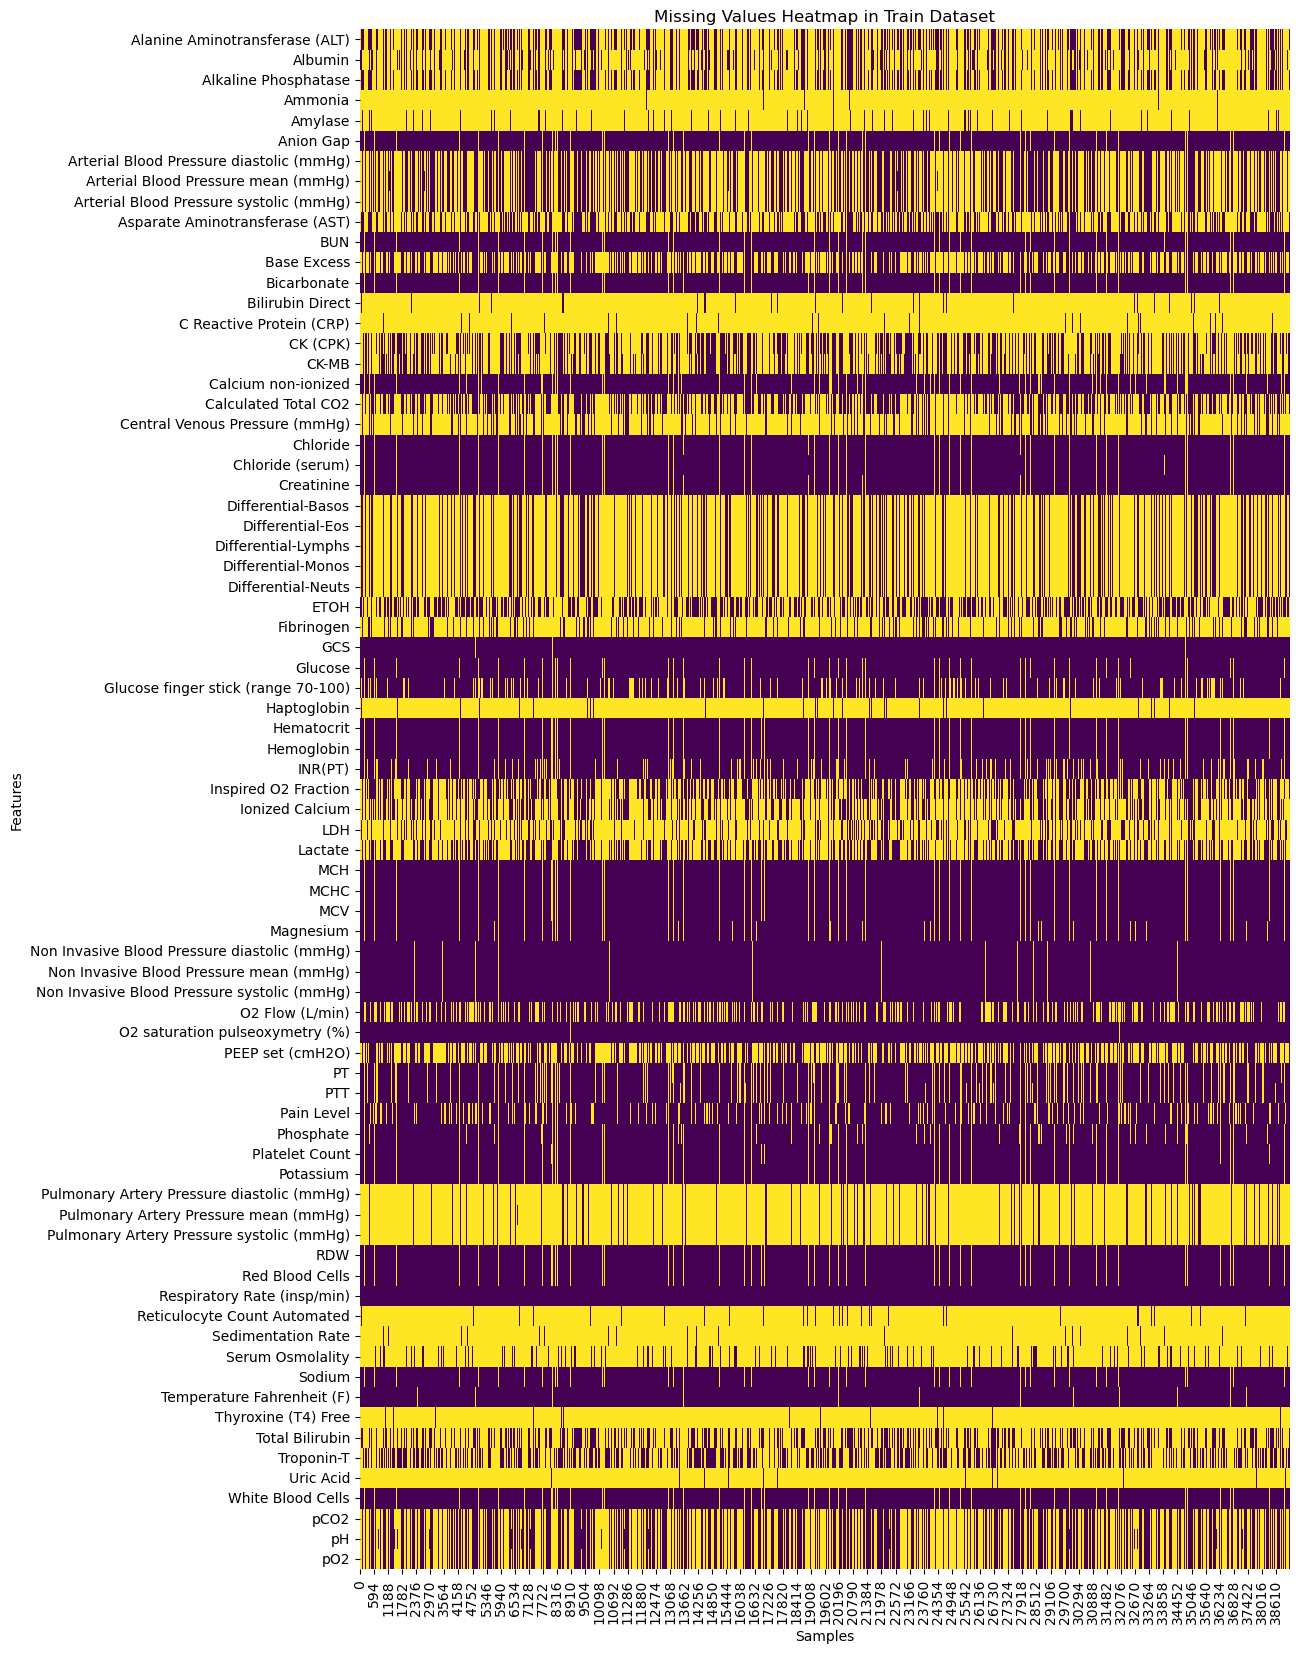

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_missing_values_heatmap(df, title='Missing Values Heatmap'):
    # Filter columns with missing values and sort them alphabetically
    df_with_missing = df.loc[:, df.isnull().any()].sort_index(axis=1)
    
    # Adjust the figure size based on the number of features with missing values
    plt.figure(figsize=(12, min(0.5 * df_with_missing.shape[1], 20)))

    # Create the heatmap
    sns.heatmap(df_with_missing.isnull().T, cbar=False, cmap='viridis')
    
    # Add titles and labels
    plt.title(title)
    plt.xlabel('Samples')
    plt.ylabel('Features')

    # Display the plot
    plt.show()

# Usage example
plot_missing_values_heatmap(X_train, title='Missing Values Heatmap in Train Dataset')

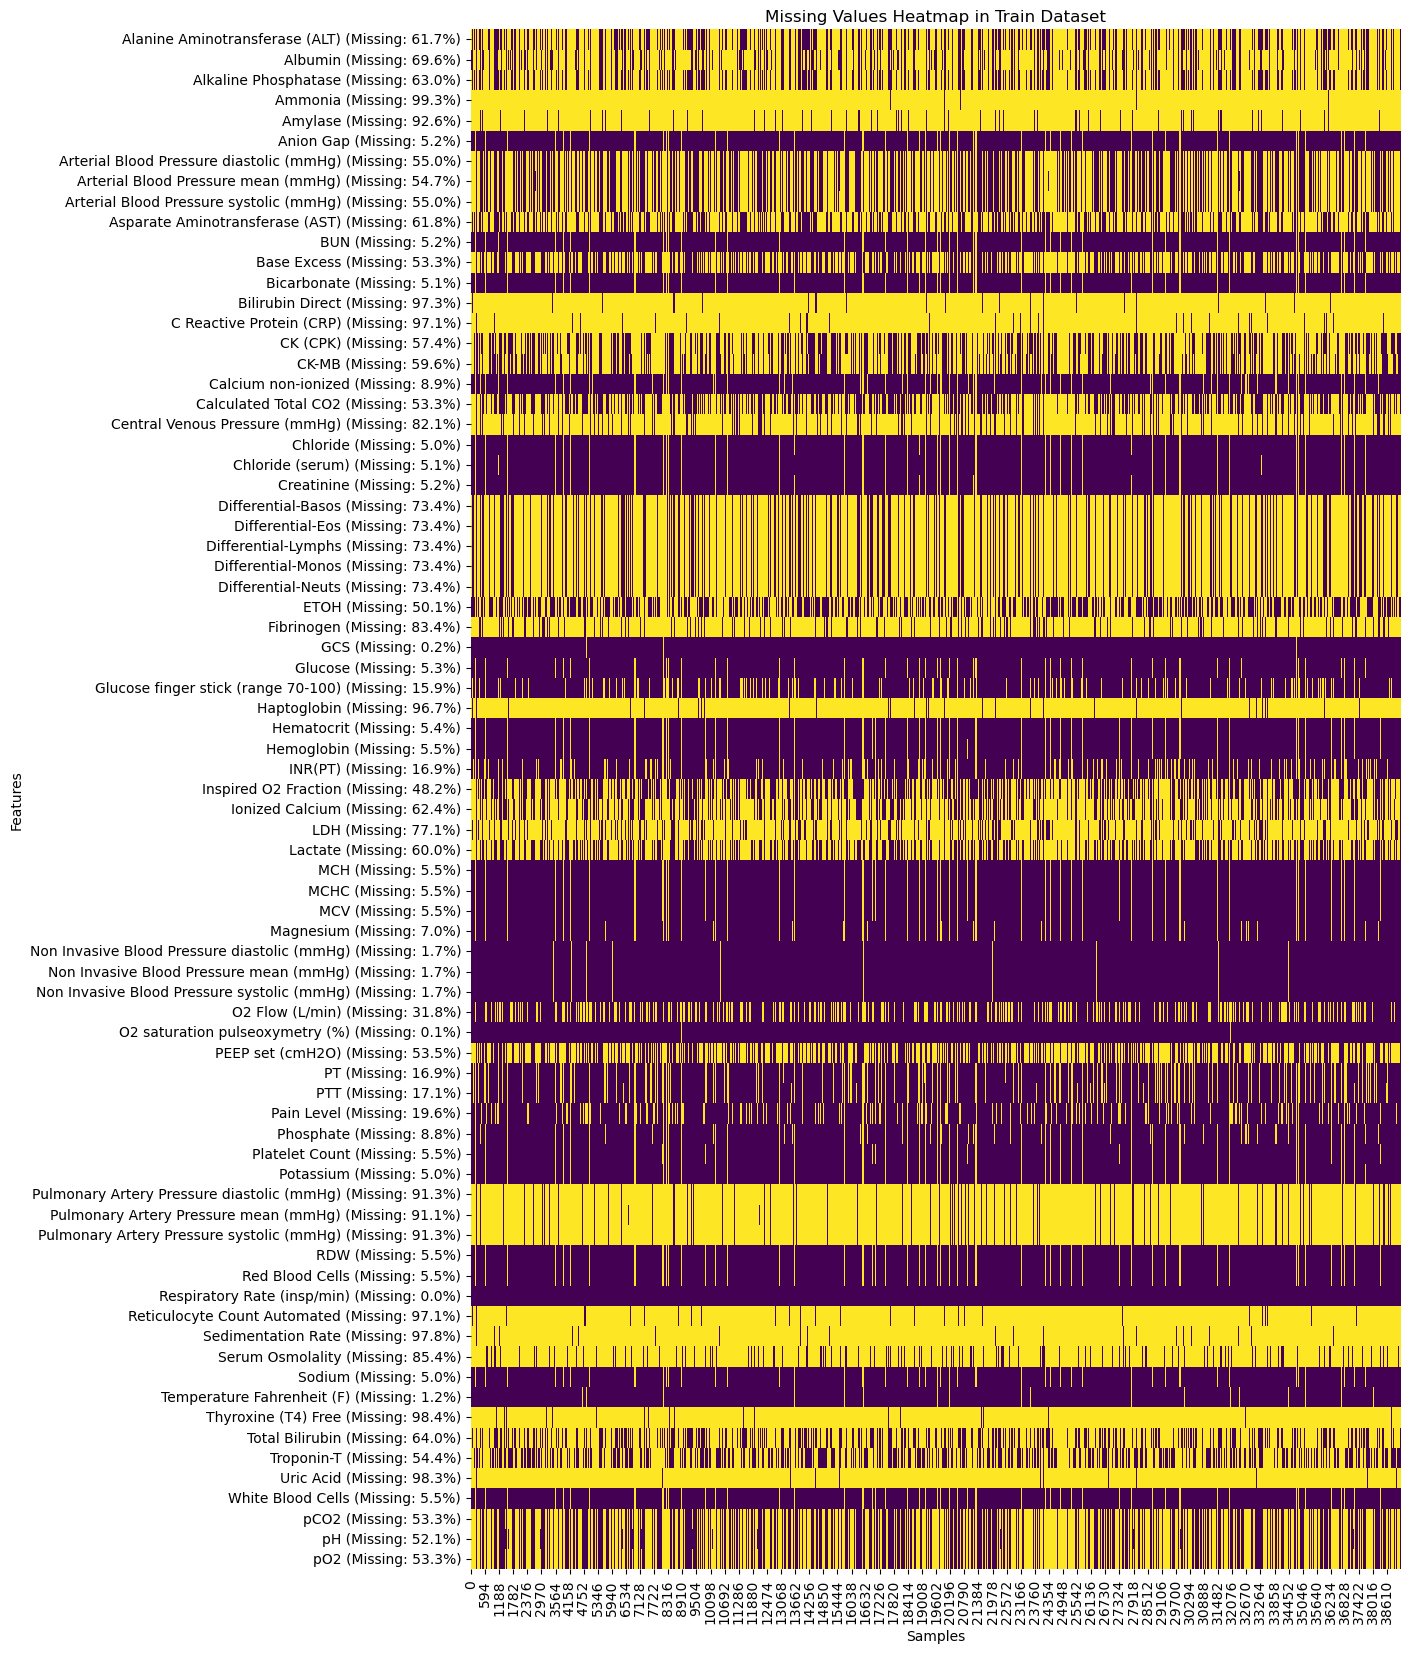

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_missing_values_heatmap(df, title='Missing Values Heatmap', save_path=None):
    # Filter columns with missing values
    df_with_missing = df.loc[:, df.isnull().any()].sort_index(axis=1)
    
    # Calculate the percentage of missing values for each feature
    missing_percentages = df_with_missing.isnull().mean() * 100
    
    # Adjust the figure size based on the number of features with missing values
    plt.figure(figsize=(12, min(0.5 * df_with_missing.shape[1], 20)))

    # Create the heatmap
    sns.heatmap(df_with_missing.isnull().T, cbar=False, cmap='viridis')
    
    # Add percentage labels to the left of each row
    plt.yticks(ticks=plt.yticks()[0], labels=[f'{col} (Missing: {missing_percentages[col]:.1f}%)' for col in df_with_missing.columns], rotation=0)
    
    # Add titles and labels
    plt.title(title)
    plt.xlabel('Samples')
    plt.ylabel('Features')
    
    # Save the plot (optional)
    plt.savefig('missing_values_heatmap.png', bbox_inches='tight')
    
    # Display the plot
    plt.show()

# Usage example
plot_missing_values_heatmap(X_train, title='Missing Values Heatmap in Train Dataset')

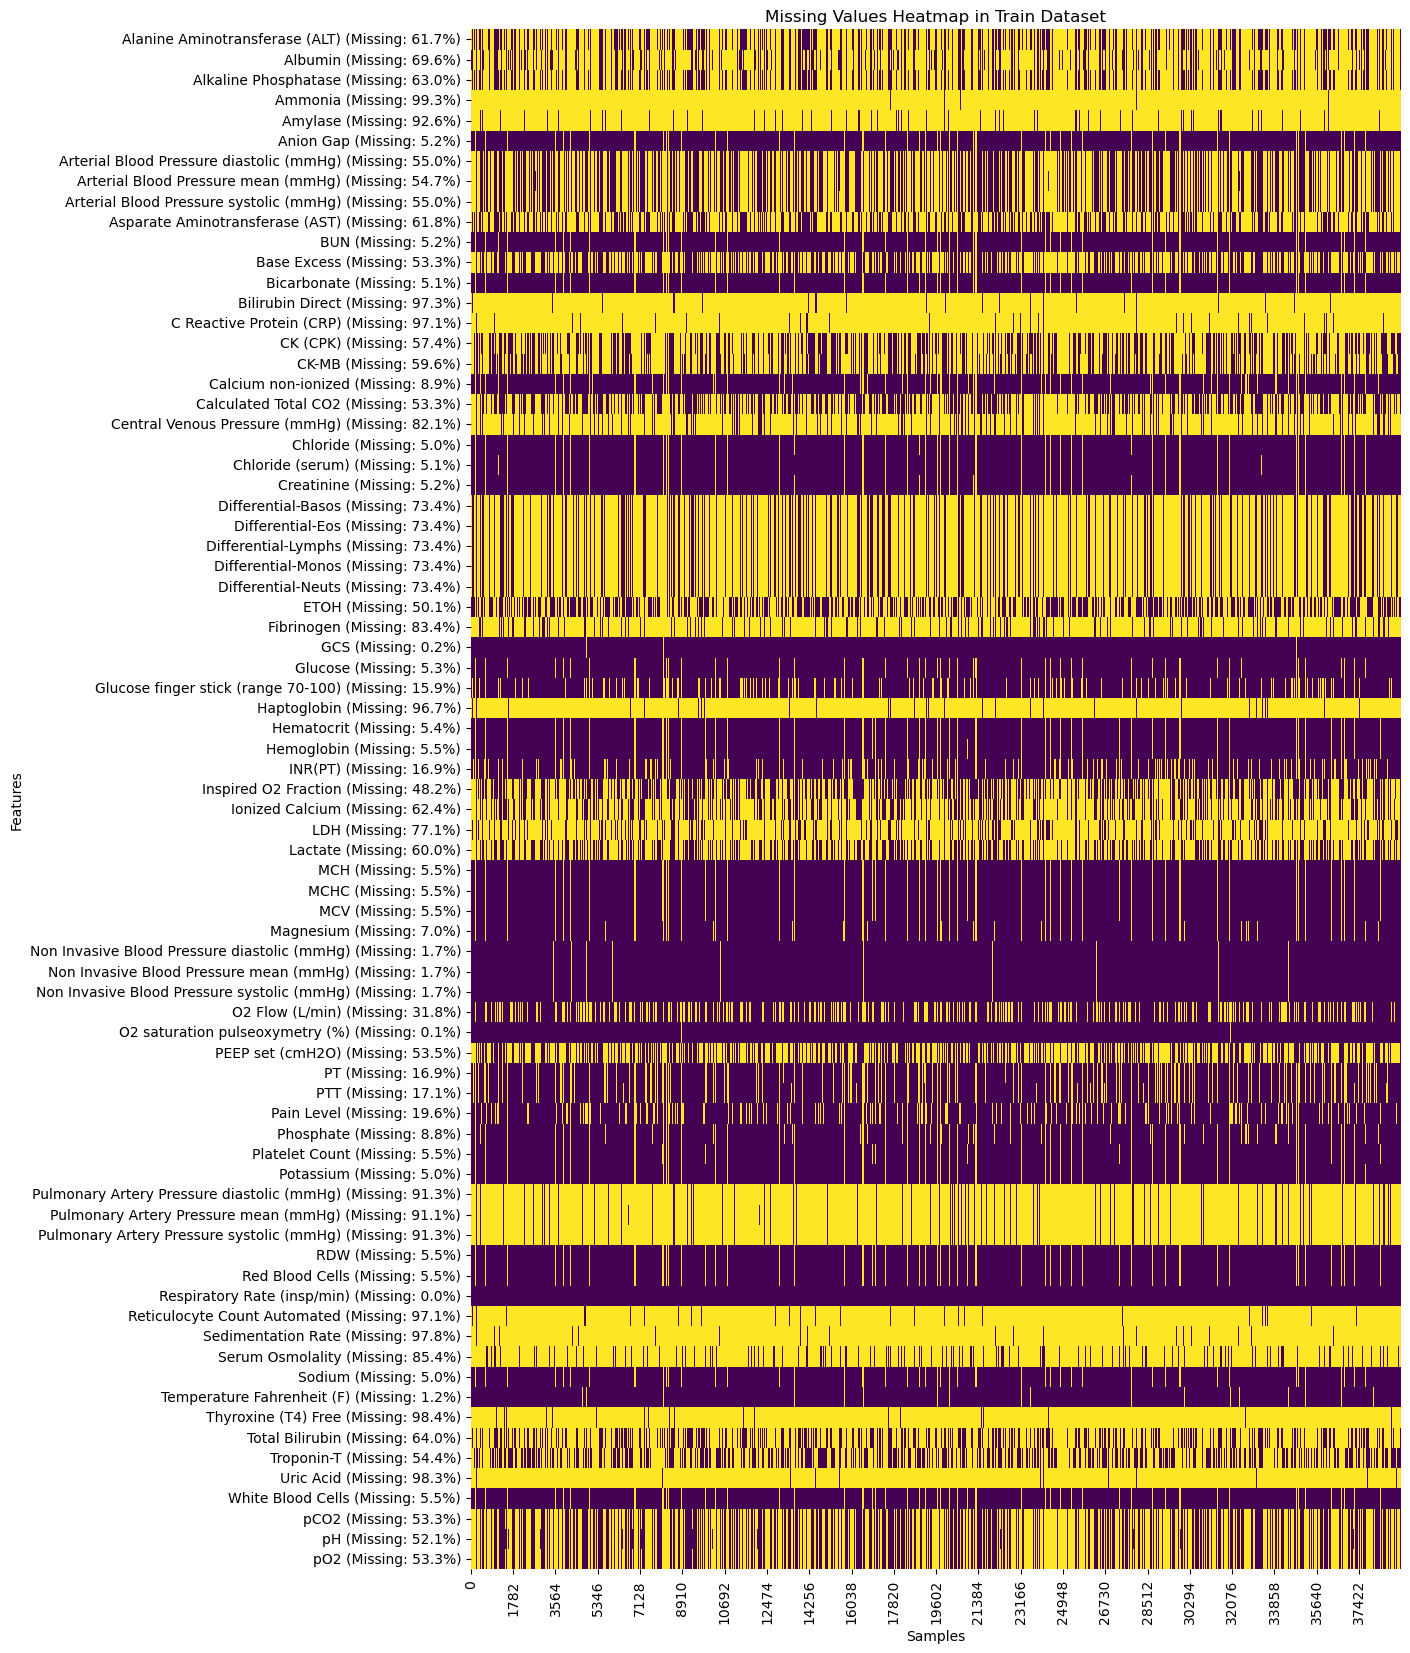

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_missing_values_heatmap(df, title='Missing Values Heatmap', save_path=None):
    # Filter columns with missing values
    df_with_missing = df.loc[:, df.isnull().any()].sort_index(axis=1)
    
    # Calculate the percentage of missing values for each feature
    missing_percentages = df_with_missing.isnull().mean() * 100
    
    # Adjust the figure size based on the number of features with missing values
    plt.figure(figsize=(12, min(0.5 * df_with_missing.shape[1], 20)))

    # Create the heatmap
    sns.heatmap(df_with_missing.isnull().T, cbar=False, cmap='viridis')
    
    # Set x-ticks to increment by 1188
    num_samples = df_with_missing.shape[0]
    xtick_positions = np.arange(0, num_samples, 1782)
    plt.xticks(ticks=xtick_positions, labels=xtick_positions)
    
    # Add percentage labels to the left of each row
    plt.yticks(ticks=plt.yticks()[0], labels=[f'{col} (Missing: {missing_percentages[col]:.1f}%)' for col in df_with_missing.columns], rotation=0)
    
    # Add titles and labels
    plt.title(title)
    plt.xlabel('Samples')
    plt.ylabel('Features')
    
    # Save the plot (optional)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    # Display the plot
    plt.show()

# Usage example
plot_missing_values_heatmap(X_train, title='Missing Values Heatmap in Train Dataset', save_path='missing_values_heatmap_custom_ticks.png')

                                         Feature  Missing Percentage
0                                        Ammonia           99.265006
1                            Thyroxine (T4) Free           98.366680
2                                      Uric Acid           98.325847
3                             Sedimentation Rate           97.754185
4                               Bilirubin Direct           97.345855
..                                           ...                 ...
71  Non Invasive Blood Pressure diastolic (mmHg)            1.714986
72                    Temperature Fahrenheit (F)            1.224990
73                                           GCS            0.204165
74               O2 saturation pulseoxymetry (%)            0.081666
75                   Respiratory Rate (insp/min)            0.040833

[76 rows x 2 columns]


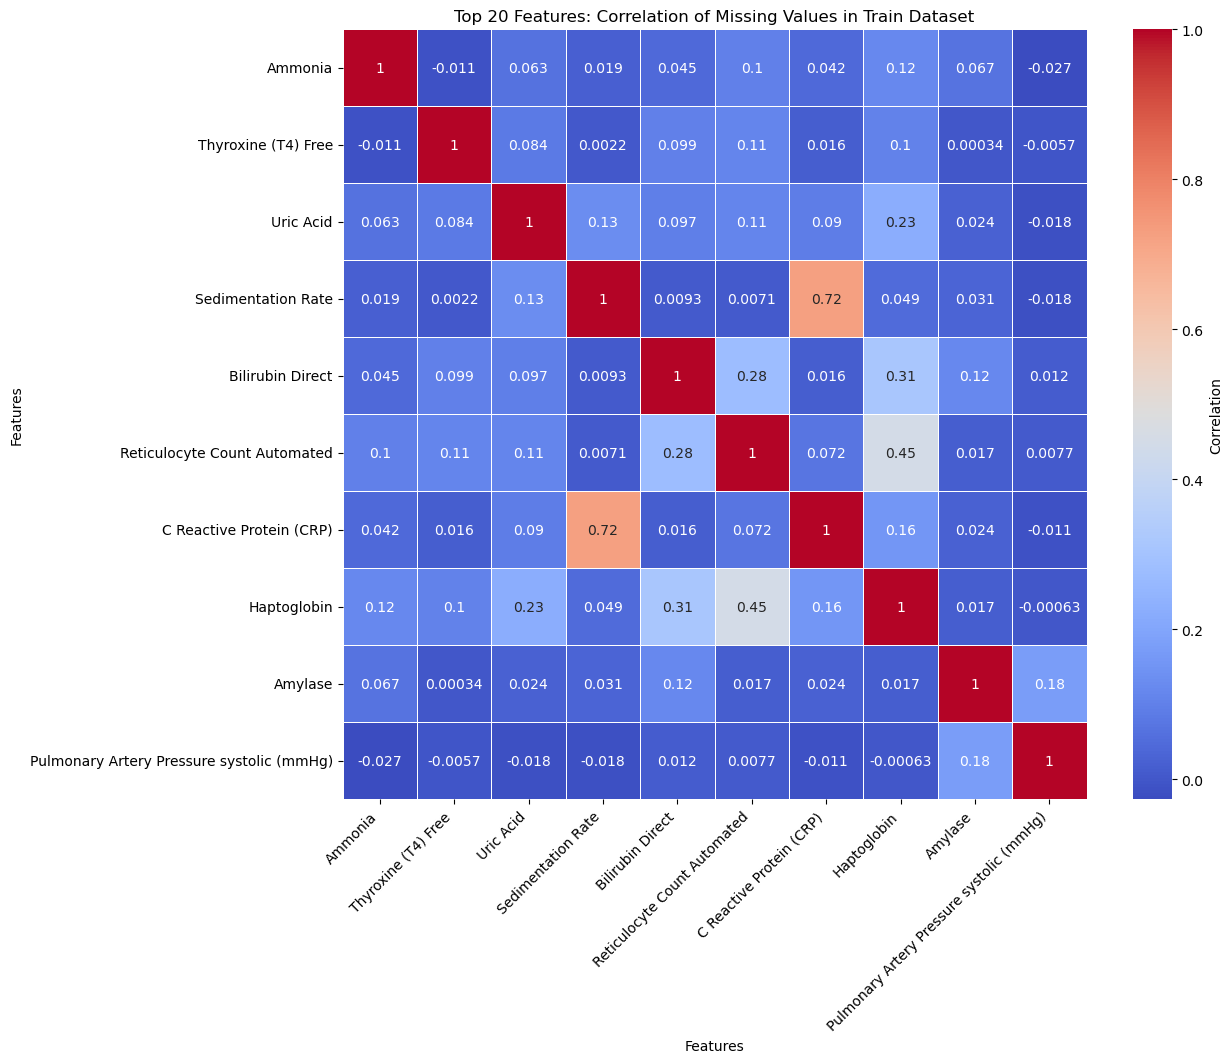

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def summarize_missing_values(df):
    # Calculate the percentage of missing values for each feature
    missing_percentages = df.isnull().mean() * 100
    # Filter features with missing values and sort them in descending order
    missing_summary = missing_percentages[missing_percentages > 0].sort_values(ascending=False).reset_index()
    missing_summary.columns = ['Feature', 'Missing Percentage']
    
    return missing_summary

def plot_missing_values_correlation(df, top_n=10, title='Missing Values Correlation Heatmap', save_path=None):
    # Filter columns with missing values and select the top N features
    df_with_missing = df.loc[:, df.isnull().mean().sort_values(ascending=False).index[:top_n]]

    # Create a dataframe indicating missing values as binary (1 for missing, 0 for present)
    missing_binary = df_with_missing.isnull().astype(int)
    
    # Calculate the correlation matrix for missing values
    corr_matrix = missing_binary.corr()
    
    # Set up the figure size
    plt.figure(figsize=(12, 10))
    
    # Create a heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, cbar_kws={'label': 'Correlation'})
    
    # Add titles and labels
    plt.title(title)
    plt.xlabel('Features')
    plt.ylabel('Features')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Save the plot (optional)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    # Display the plot
    plt.show()

# Usage example
missing_summary_df = summarize_missing_values(X_train)

# Display the summary table
print(missing_summary_df)

# Plot the correlation of missing values for the top features with the most missing values
plot_missing_values_correlation(X_train, top_n=10, title='Top 20 Features: Correlation of Missing Values in Train Dataset', save_path='missing_values_correlation_heatmap.png')

# Optionally, save the summary to a CSV file
missing_summary_df.to_csv('missing_values_summary.csv', index=False)


                                         Feature  Missing Percentage
0                                        Ammonia           99.265006
1                            Thyroxine (T4) Free           98.366680
2                                      Uric Acid           98.325847
3                             Sedimentation Rate           97.754185
4                               Bilirubin Direct           97.345855
..                                           ...                 ...
71  Non Invasive Blood Pressure diastolic (mmHg)            1.714986
72                    Temperature Fahrenheit (F)            1.224990
73                                           GCS            0.204165
74               O2 saturation pulseoxymetry (%)            0.081666
75                   Respiratory Rate (insp/min)            0.040833

[76 rows x 2 columns]


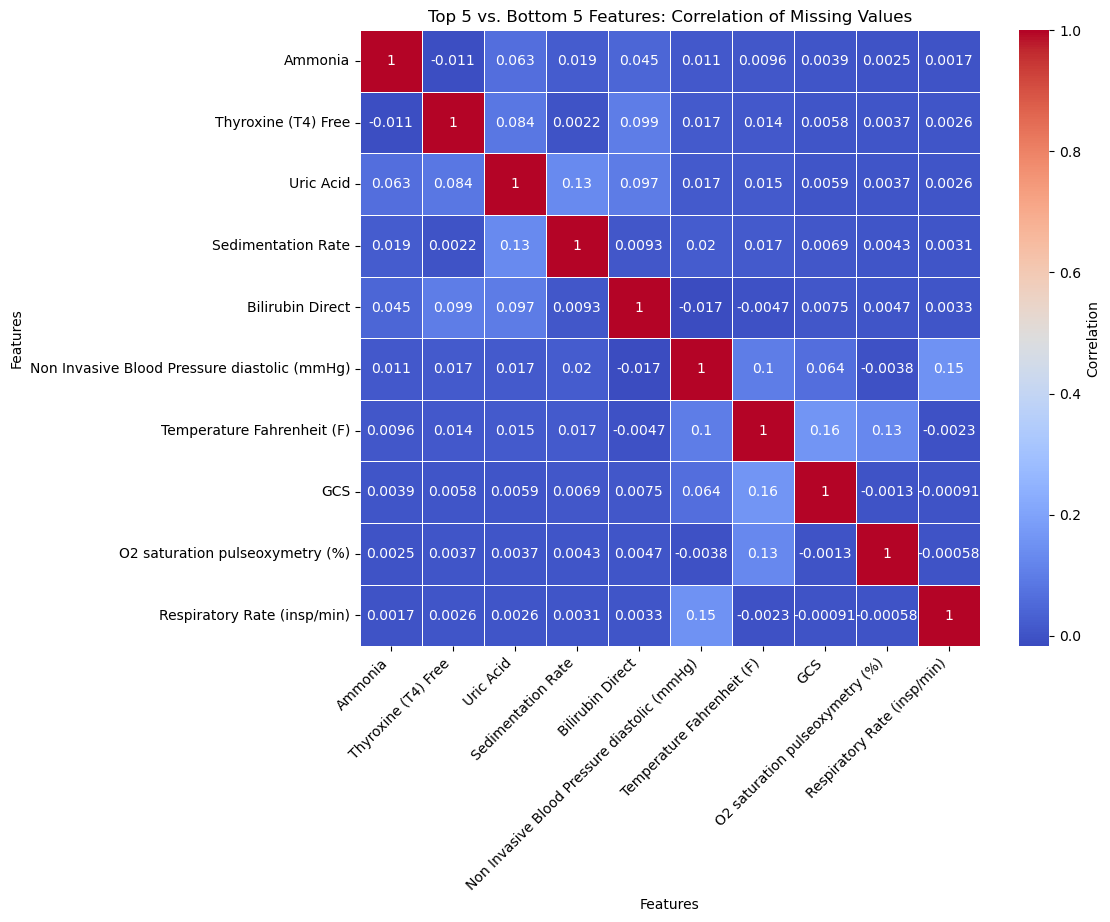

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def summarize_missing_values(df):
    # Calculate the percentage of missing values for each feature
    missing_percentages = df.isnull().mean() * 100
    # Filter features with missing values and sort them in descending order
    missing_summary = missing_percentages[missing_percentages > 0].sort_values(ascending=False).reset_index()
    missing_summary.columns = ['Feature', 'Missing Percentage']
    
    return missing_summary

def plot_mixed_correlation(df, missing_summary_df, title='Top 5 vs. Bottom 5 Missing Values Correlation Heatmap', save_path=None):
    # Extract the top 5 features with the most missing values
    top_5_features = missing_summary_df.head(5)['Feature']
    # Extract the 5 features with the lowest missing values
    bottom_5_features = missing_summary_df.tail(5)['Feature']

    # Combine these features into a single list
    selected_features = pd.concat([top_5_features, bottom_5_features])

    # Filter the dataframe to include only the selected features
    df_mixed = df[selected_features]

    # Create a dataframe indicating missing values as binary (1 for missing, 0 for present)
    missing_binary = df_mixed.isnull().astype(int)
    
    # Calculate the correlation matrix for missing values
    corr_matrix = missing_binary.corr()
    
    # Set up the figure size
    plt.figure(figsize=(10, 8))
    
    # Create a heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, cbar_kws={'label': 'Correlation'})
    
    # Add titles and labels
    plt.title(title)
    plt.xlabel('Features')
    plt.ylabel('Features')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Save the plot if a path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    # Display the plot
    plt.show()

# Usage example
missing_summary_df = summarize_missing_values(X_train)

# Display the summary table
print(missing_summary_df)

# Plot the correlation between the top 5 and bottom 5 features with missing values and save the plot
plot_mixed_correlation(X_train, missing_summary_df, title='Top 5 vs. Bottom 5 Features: Correlation of Missing Values', save_path='top5_vs_bottom5_missing_values_correlation.png')

# Optionally, save the summary to a CSV file
missing_summary_df.to_csv('missing_values_summary.csv', index=False)

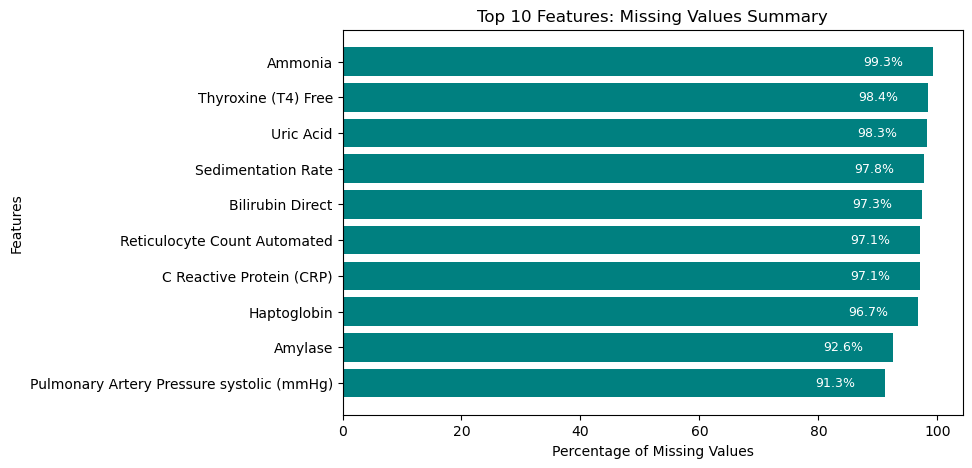

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

def summarize_missing_values(df):
    # Calculate the percentage of missing values for each feature
    missing_percentages = df.isnull().mean() * 100
    # Filter features with missing values and sort them in descending order
    missing_summary = missing_percentages[missing_percentages > 0].sort_values(ascending=False).reset_index()
    missing_summary.columns = ['Feature', 'Missing Percentage']
    
    return missing_summary

def plot_top_missing_values(df, title='Top 10 Features: Missing Values Summary', top_n=10, save_path=None):
    # Select the top n features with the most missing values
    df = df.head(top_n)
    
    # Set up the figure size
    plt.figure(figsize=(8, 5))
    
    # Create a bar plot
    bars = plt.barh(df['Feature'], df['Missing Percentage'], color='teal')
    
    # Add percentage labels inside the bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width - 5, bar.get_y() + bar.get_height() / 2, f'{width:.1f}%', ha='right', va='center', color='white', fontsize=9)
    
    # Add titles and labels
    plt.title(title)
    plt.xlabel('Percentage of Missing Values')
    plt.ylabel('Features')
    
    # Invert y-axis to show the highest missing values at the top
    plt.gca().invert_yaxis()
    
    # Save the plot (optional)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    # Display the plot
    plt.show()

# Usage example
missing_summary_df = summarize_missing_values(X_train)

# Plot only the top 10 features with the most missing values
plot_top_missing_values(missing_summary_df, title='Top 10 Features: Missing Values Summary', top_n=10, save_path='top_10_missing_values_summary.png')


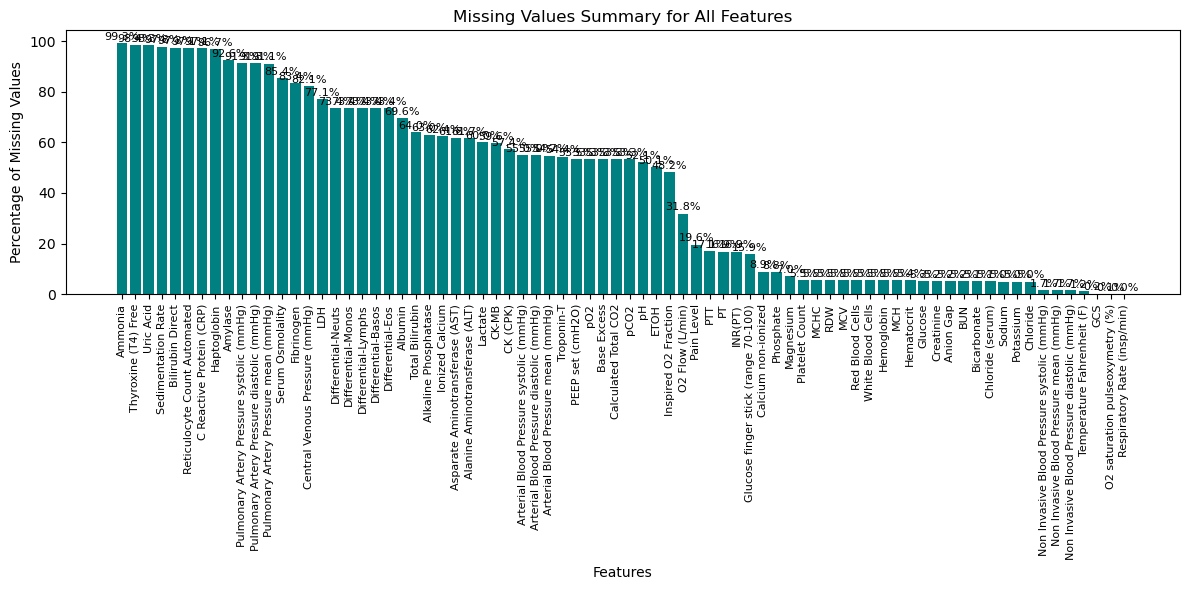

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

def summarize_missing_values(df):
    # Calculate the percentage of missing values for each feature
    missing_percentages = df.isnull().mean() * 100
    # Filter features with missing values and sort them in descending order
    missing_summary = missing_percentages[missing_percentages > 0].sort_values(ascending=False).reset_index()
    missing_summary.columns = ['Feature', 'Missing Percentage']
    
    return missing_summary

def plot_condensed_missing_summary(df, title='Missing Values Summary for All Features', save_path=None):
    # Sort features by the percentage of missing values
    df = df.sort_values(by='Missing Percentage', ascending=False)
    
    # Set up the figure size
    plt.figure(figsize=(12, 6))  # Wider than taller for a more compact view
    
    # Create a horizontal bar plot
    bars = plt.bar(df['Feature'], df['Missing Percentage'], color='teal')
    
    # Add percentage labels above the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height:.1f}%', ha='center', va='bottom', fontsize=8)
    
    # Add titles and labels
    plt.title(title)
    plt.xlabel('Features')
    plt.ylabel('Percentage of Missing Values')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90, ha='center', fontsize=8)
    
    # Set tight layout to save space
    plt.tight_layout()
    
    # Save the plot (optional)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    # Display the plot
    plt.show()

# Usage example
missing_summary_df = summarize_missing_values(X_train)

# Plot the condensed summary for all features with missing values
plot_condensed_missing_summary(missing_summary_df, title='Missing Values Summary for All Features', save_path='condensed_missing_values_summary.png')


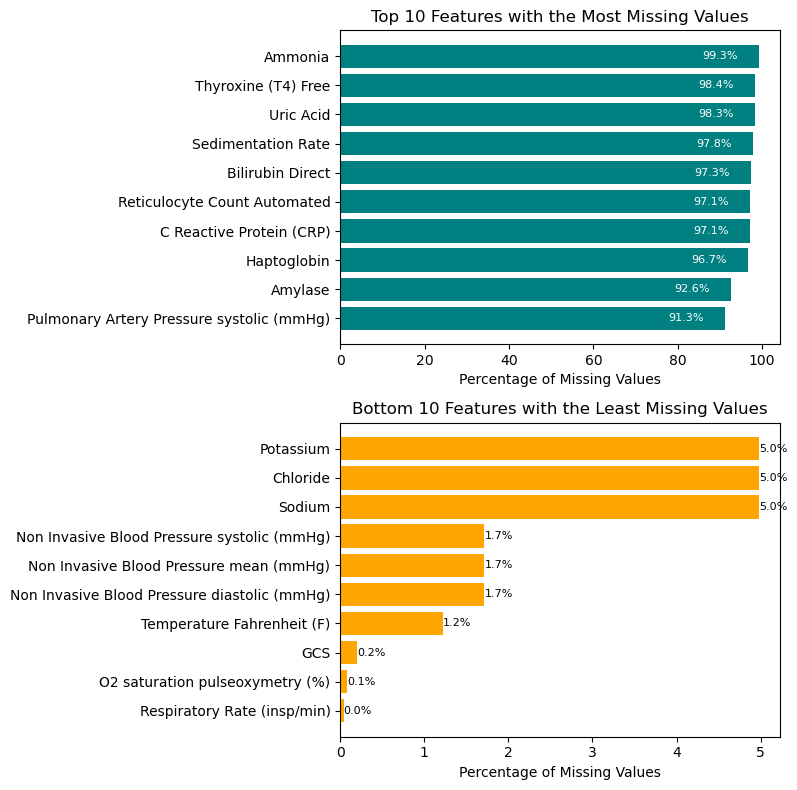

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

def summarize_missing_values(df):
    # Calculate the percentage of missing values for each feature
    missing_percentages = df.isnull().mean() * 100
    # Filter features with missing values and sort them in descending order
    missing_summary = missing_percentages[missing_percentages > 0].sort_values(ascending=False).reset_index()
    missing_summary.columns = ['Feature', 'Missing Percentage']
    
    return missing_summary

def plot_top_and_bottom_missing(df, top_n=10, bottom_n=10, save_path=None):
    # Sort and select top_n features with the most missing values
    top_features = df.head(top_n)
    # Sort and select bottom_n features with the least missing values
    bottom_features = df.tail(bottom_n)
    
    # Set up the figure with two subplots
    fig, axes = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [1, 1]})
    
    # Plot top features (most missing values)
    bars_top = axes[0].barh(top_features['Feature'], top_features['Missing Percentage'], color='teal')
    axes[0].set_title(f'Top {top_n} Features with the Most Missing Values')
    axes[0].set_xlabel('Percentage of Missing Values')
    axes[0].invert_yaxis()  # Highest missing at the top
    
    # Add percentage labels inside the bars for the top plot
    for bar in bars_top:
        width = bar.get_width()
        axes[0].text(width - 5, bar.get_y() + bar.get_height() / 2, f'{width:.1f}%', ha='right', va='center', color='white', fontsize=8)
    
    # Plot bottom features (least missing values)
    bars_bottom = axes[1].barh(bottom_features['Feature'], bottom_features['Missing Percentage'], color='orange')
    axes[1].set_title(f'Bottom {bottom_n} Features with the Least Missing Values')
    axes[1].set_xlabel('Percentage of Missing Values')
    axes[1].invert_yaxis()  # Lowest missing at the top
    
    # Add percentage labels slightly to the left for the bottom plot
    for bar in bars_bottom:
        width = bar.get_width()
        if width < 10:  # For small bars, place the label to the left
            axes[1].text(width + 0.0, bar.get_y() + bar.get_height() / 2, f'{width:.1f}%', ha='left', va='center', fontsize=8)
        else:  # For larger bars, place the label inside
            axes[1].text(width - 5, bar.get_y() + bar.get_height() / 2, f'{width:.1f}%', ha='right', va='center', color='white', fontsize=8)
    
    # Tight layout for spacing
    plt.tight_layout()
    
    # Save the combined plot (optional)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    # Show the plot
    plt.show()

# Usage example
missing_summary_df = summarize_missing_values(X_train)

# Plot the top 10 and bottom 10 features by missing values
plot_top_and_bottom_missing(missing_summary_df, top_n=10, bottom_n=10, save_path='top_and_bottom_missing_values.png')


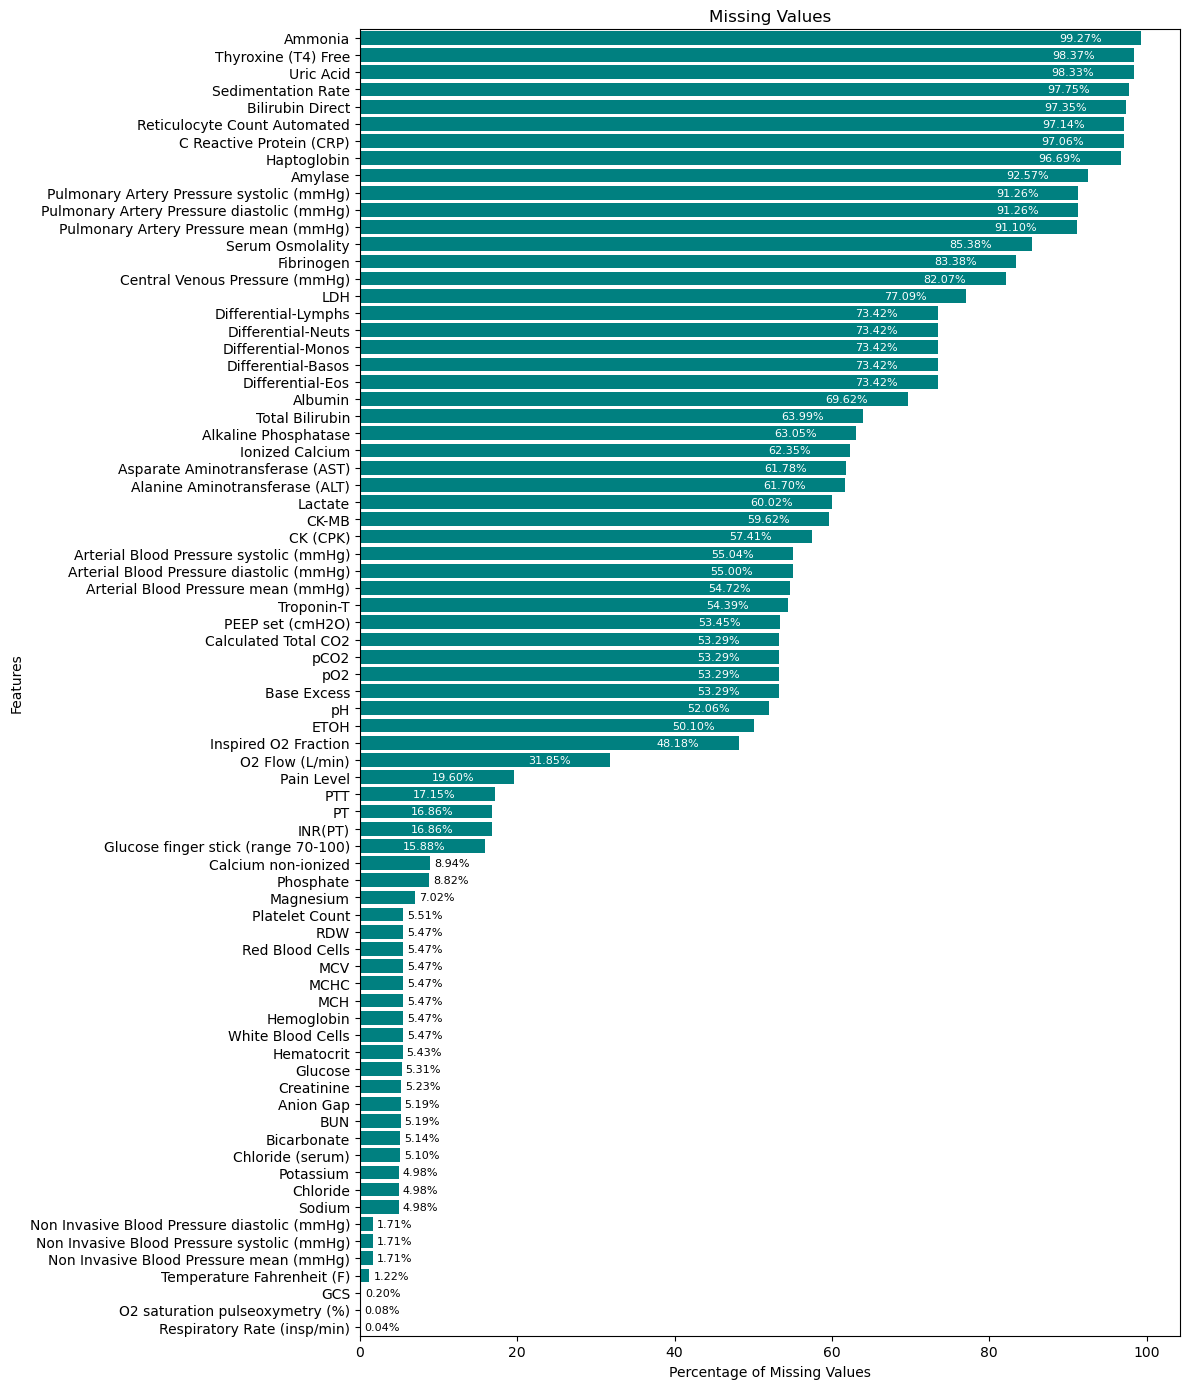

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

def summarize_missing_values(df):
    # Calculate the percentage of missing values for each feature
    missing_percentages = df.isnull().mean() * 100
    # Filter features with missing values and sort them in descending order
    missing_summary = missing_percentages[missing_percentages > 0].sort_values(ascending=False).reset_index()
    missing_summary.columns = ['Feature', 'Missing Percentage']
    
    return missing_summary

def plot_condensed_missing_summary(df, title='Missing Values Summary for All Features', save_path=None):
    # Sort features by the percentage of missing values
    df = df.sort_values(by='Missing Percentage', ascending=True)
    
    # Set up the figure size to be wider and fit all features
    plt.figure(figsize=(12, 14))  # Adjust height to fit all 76 features
    
    # Create a horizontal bar plot
    bars = plt.barh(df['Feature'], df['Missing Percentage'], color='teal')
    
    # Add percentage labels on the bars
    for bar in bars:
        width = bar.get_width()
        # For very small bars, place the label to the right
        if width < 10:
            plt.text(width + 0.5, bar.get_y() + bar.get_height() / 2, f'{width:.2f}%', ha='left', va='center', fontsize=8)
        else:
            plt.text(width - 5, bar.get_y() + bar.get_height() / 2, f'{width:.2f}%', ha='right', va='center', color='white', fontsize=8)
    
    # Add titles and labels
    plt.title(title)
    plt.xlabel('Percentage of Missing Values')
    plt.ylabel('Features')
    
    # Invert y-axis to show features with the highest missing values at the top
    plt.gca().invert_yaxis()
    
    # Remove gaps by setting y-limits
    plt.ylim(-0.5, len(df) - 0.5)
    
    # Adjust layout to make space for labels
    plt.tight_layout()
    
    # Save the plot (optional)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    # Show the plot
    plt.show()

# Usage example
missing_summary_df = summarize_missing_values(X_train)

# Plot the condensed summary for all features with missing values
plot_condensed_missing_summary(missing_summary_df, title='Missing Values', save_path='04_missing_values.png')


# Correlation Analysis

In [ ]:
import numpy as np

# Function to plot the correlation matrix, filtering by correlation strength
def plot_filtered_correlations(df, threshold, title='Filtered Feature Correlation Matrix', save_path=None):
    # Calculate the correlation matrix for all features
    corr_matrix = df.corr()

    # Filter correlations that are above the threshold (in absolute terms) and not self-correlations
    filtered_corr = corr_matrix[(np.abs(corr_matrix) >= threshold) & (corr_matrix != 1.0)]

    # Plot the filtered correlation matrix as a heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(filtered_corr, annot=False, cmap='coolwarm', linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Correlation'}, mask=filtered_corr.isnull())
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Save the plot if a path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    # Display the plot
    plt.show()

# Plot correlations above the threshold (e.g., 0.7)
plot_filtered_correlations(X_train, threshold=0.6, title='Filtered Feature Correlation Matrix (Threshold 0.7)', save_path='filtered_correlation_matrix.png')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot the correlation matrix for all features
def plot_all_feature_correlations(df, title='Feature Correlation Matrix (All Features)', save_path=None):
    # Calculate the correlation matrix for all features
    corr_matrix = df.corr()

    # Plot the correlation matrix as a heatmap
    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Correlation'})
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Save the plot if a path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    # Display the plot
    plt.show()

# Plot the correlation matrix for all features
plot_all_feature_correlations(X_train, title='Feature Correlation Matrix (All Features)', save_path='all_features_correlation_matrix.png')


In [ ]:
import pandas as pd

# Set pandas display option to show all columns
pd.set_option('display.max_rows', None)

# Check the data types of the features
print(X_train.dtypes)

# Check for features with low variance
low_variance_features = X_train.columns[X_train.nunique() <= 1]
print(f"Features with low variance (constant or near-constant): {low_variance_features.tolist()}")

# Reset the option to its default value if needed
pd.reset_option('display.max_rows')

In [ ]:
# Compute the correlation matrix for all features
corr_matrix = X_train.corr()

# Set pandas display option to show all columns
pd.set_option('display.max_rows', None)
# Check the correlation values for "GCS"
gcs_correlations = corr_matrix['GCS'].sort_values(ascending=False)
print(gcs_correlations)# Reset the option to its default value if needed
pd.reset_option('display.max_rows')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the full correlation matrix without filtering
def plot_full_correlation_matrix(df, title='Full Feature Correlation Matrix', save_path=None):
    corr_matrix = df.corr()

    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Correlation'})
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

# Plot the full correlation matrix for all features
plot_full_correlation_matrix(X_train, title='Full Feature Correlation Matrix (All Features)', save_path='all_features_correlation_matrix.png')


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot the correlation matrix, filtering out specific patterns (e.g., features starting with 'race_')
def plot_filtered_correlations_no_race(df, threshold, exclude_pattern='race_', title='Filtered Feature Correlation Matrix', save_path=None):
    # Exclude columns containing the specified pattern
    df_filtered = df.loc[:, ~df.columns.str.startswith(exclude_pattern)]
    
    # Calculate the correlation matrix for the filtered features
    corr_matrix = df_filtered.corr()

    # Filter correlations that are above the threshold (in absolute terms) and not self-correlations
    filtered_corr = corr_matrix[(np.abs(corr_matrix) >= threshold) & (corr_matrix != 1.0)]

    # Plot the filtered correlation matrix as a heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(filtered_corr, annot=False, cmap='coolwarm', linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Correlation'}, mask=filtered_corr.isnull())
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Save the plot if a path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    # Display the plot
    plt.show()

# Example usage
plot_filtered_correlations_no_race(X_train, threshold=0.5, title='Feature Correlation Matrix (Threshold 0.5)', save_path='filtered_correlation_matrix_05.png')